In [1]:
import numpy as np
import tensorflow as tf
from DeepAnt import DeepAnt
from WindowGen import WindowGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

UCR_250_weallwalk 2951 [7290, 7296]


[]

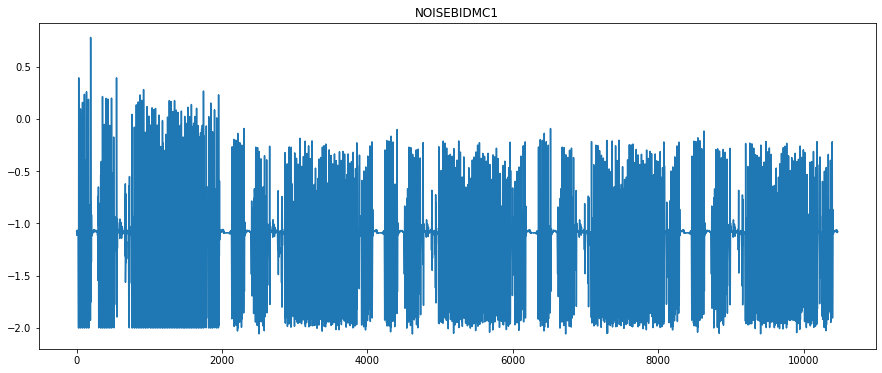

In [31]:
#df = pd.read_csv('data/TravelTime_451.csv', index_col = 'timestamp', parse_dates=['timestamp'])
path = '/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/250_UCR_Anomaly_weallwalk_2951_7290_7296.txt'
#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/182_UCR_Anomaly_qtdbSel1005V_4000_12400_12800.txt'


#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/222_UCR_Anomaly_mit14046longtermecg_56123_91200_91700.txt'
#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/152_UCR_Anomaly_PowerDemand1_9000_18485_18821.txt'
#'/Users/Okano700/Documents/GitHub/metaFeaturesTS/data/UCR_Anomaly_FullData/120_UCR_Anomaly_ECG2_15000_16000_16100.txt'


split_name = str(path).split('/')[-1]
split_name = str(split_name).split('.')[0]
name_aux = str(split_name).split('_')
ds_name = f"{name_aux[1]}_{name_aux[0]}_{name_aux[3]}"
m_v = int(name_aux[4])
an = [int(name_aux[5]), int(name_aux[6])]
print(ds_name, m_v, an)



df_1 = np.genfromtxt(path)
df = pd.DataFrame(df_1,columns=['value'])
df.plot(figsize = (15, 6), title = 'NOISEBIDMC1', legend = False);
y_ = np.zeros(len(df))
y_[an[0]:an[1]] =1
df['anomaly'] = y_
plt.plot()

In [32]:
from scipy.signal import periodogram
from math import floor
f, px = periodogram(np.array(df)[:,0], detrend='linear')
floor(1/f[np.argmax(px)] + 0.5)
n = 20
ind = np.argpartition(px, -n)[-n:]


print([floor(1/f[a] + 0.5) for a in px.argsort()[-n:][::-1]])
print([f[a] for a in px.argsort()[-n:][::-1]])

[8, 8, 8, 8, 8, 8, 8, 8, 24, 8, 8, 12, 8, 23, 8, 9, 8, 8, 8, 8]
[0.126862820022927, 0.12734046618265188, 0.12552541077569737, 0.1292510508215514, 0.12781811234237678, 0.1264807030951471, 0.12638517386320214, 0.12514329384791748, 0.042128391287734046, 0.12762705387848683, 0.12714940771876193, 0.08454337027130301, 0.12896446312571647, 0.04260603744745892, 0.12227741688956821, 0.11625907527703477, 0.12695834925487198, 0.12877340466182652, 0.12972869698127626, 0.12667176155903706]


In [34]:
w_l = 2*8
p_w = 1

In [35]:
ds = WindowGenerator(input_width= w_l, label_width= p_w, shift = 1, train_df = df['value'].loc[:m_v].to_frame(), test_df = df['value'].to_frame(), val_df = df['value'].to_frame())

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


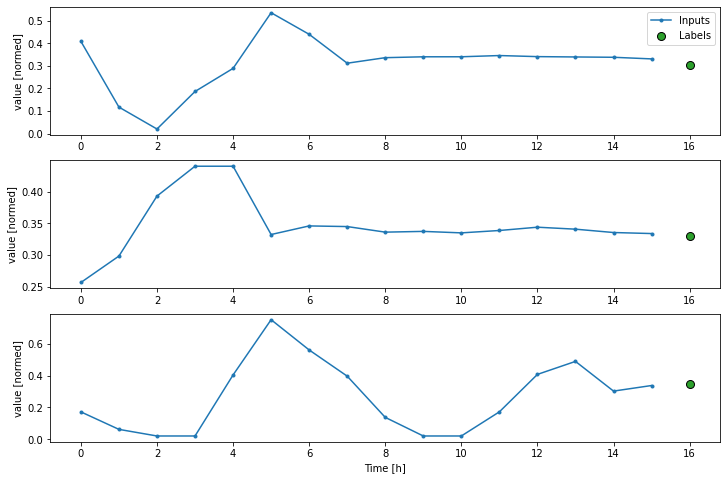

In [36]:
ds.plot(plot_col='value')

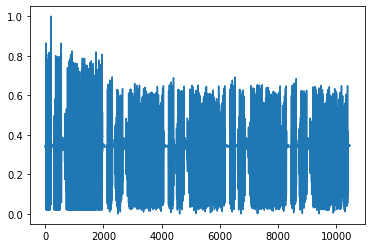

In [37]:
plt.plot(ds.scaler.transform(df['value'].to_frame()))

In [38]:
ds.make_dataset(df['value'].to_frame())

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


<MapDataset shapes: ((None, 16, 1), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [39]:
DA = DeepAnt(w_l = w_l)

In [40]:
def compile_and_fit(model, window,MAX_EPOCHS = 30, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [41]:
hist = compile_and_fit(DA, ds, patience =5, MAX_EPOCHS = 50)

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/50
92/92 [==============================] - 1s 9ms/step - loss: 0.0261 - mean_absolute_error: 0.1219 - val_loss: 0.0148 - val_mean_absolute_error: 0.0914
Epoch 2/50
92/92 [==============================] - 1s 8ms/step - loss: 0.0185 - mean_absolute_error: 0.1030 - val_loss: 0.0118 - val_mean_absolute_error: 0.0807
Epoch 3/50
92/92 [==============================] - 1s 9ms/step - loss: 0.0159 - mean_absolute_error: 0.0960 - val_loss: 0.0101 - val_mean_absolute_error: 0.0728
Epoch 4/50
92/92 [==============================] - 1s 8ms/step - loss: 0.0136 - mean_absolute_error: 0.0881 - val_loss: 0.0095 - val_mean_absolute_error: 0.0796
Epoch 5/50
92/92 [==============================] - 1s 8ms/step - loss: 0.0128 - mean_absolute_error: 0.0851 - val_loss: 0.0086 - val_mean_absolute_error: 0.0693
Epoch 6/50
92/92 [==============================] - 1s 8ms/step - loss: 0.0122 - mean_absolute_error: 0.0821 - val_loss: 0.0083 - val_mean_absolute_error: 0.0701
Epoch 7/50
92/92 [==========

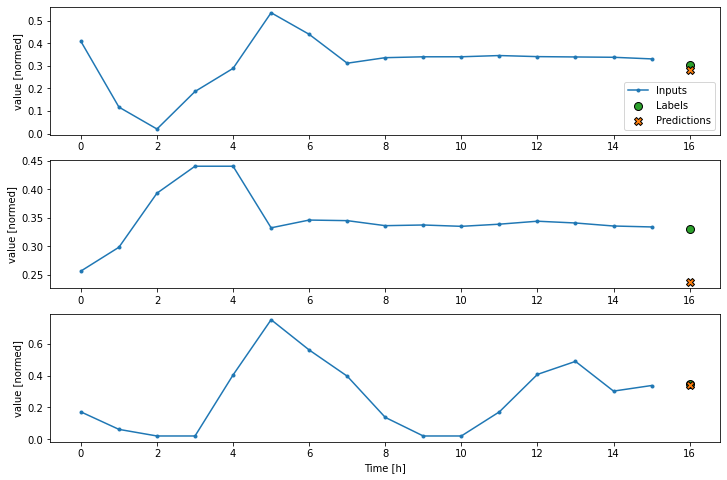

In [42]:
ds.plot(DA, plot_col='value')

In [43]:
a =ds.make_ds_pred(data = df['value'].to_frame())

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [44]:
#loss_ = []
#for X,y in a.as_numpy_iterator(): 
#    loss_.append(np.squeeze(np.abs(y- DA.predict(X))))

In [45]:
yhat, loss = DA.get_loss(a)
preds_losses = pd.Series(loss, index = np.arange(w_l,len(df)))

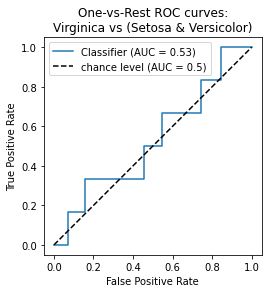

In [46]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
RocCurveDisplay.from_predictions(df['anomaly'].iloc[preds_losses.index.min():], preds_losses)
#plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
#display.plot()

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [47]:
def plot_predictions(preds, threshold, bins = 80):
    sns.displot(preds, bins = bins, kde = True, height = 8, aspect = 2)
    plt.axvline(x = threshold, color = 'r', linestyle = '--', label = 'Chosen Threshold')
    plt.title('Loss Distribution')
    plt.legend()

def loss_plot(preds, threshold):
    preds.plot(figsize = (15,8), title = 'Chosen Threshold', label = 'Loss')
    plt.axhline(y = threshold, color = 'r', linestyle = '--', label = 'Chosen Threshold')
    plt.legend()
    plt.show();

def ts_plot(df, preds, threshold, alg = 'DeepAnT', range = None):
    idx = preds.loc[lambda x: x > threshold].index
    plt.figure(figsize = (20,8))
    if range is not None:
        min, max = range
        df = df[min:max]
    plt.plot(df, label = '_nolegend_')
    plt.scatter(idx, df.loc[idx], color = 'red', label = 'Detected Anomalies by DeepAnt')
    plt.title('Detected Anomalies in Time Series')
    plt.legend()
    plt.show();

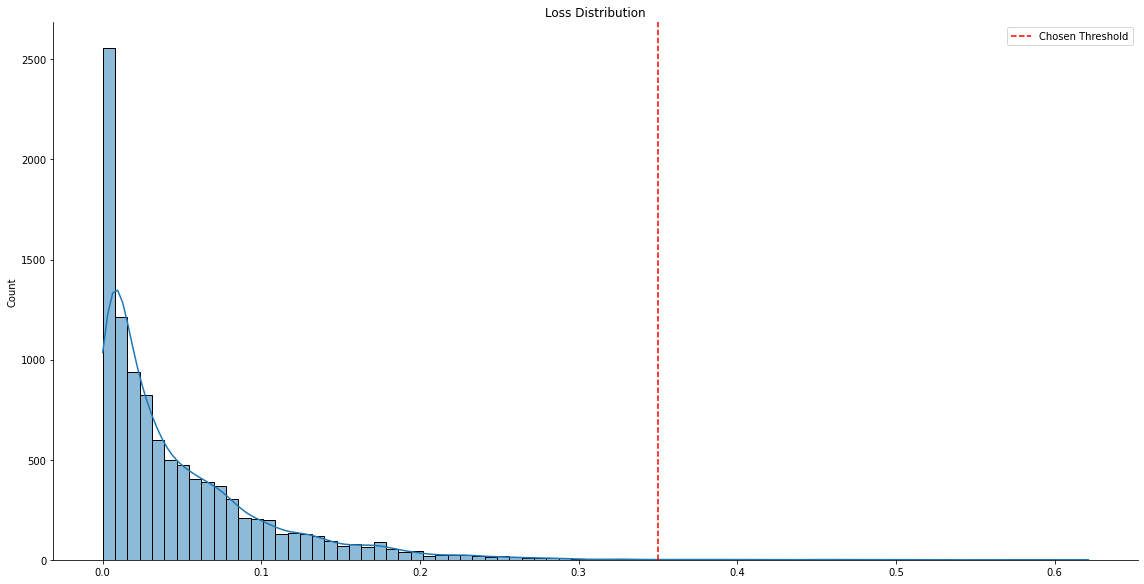

In [48]:
THRESHOLD = 0.35
plot_predictions(preds_losses, THRESHOLD)

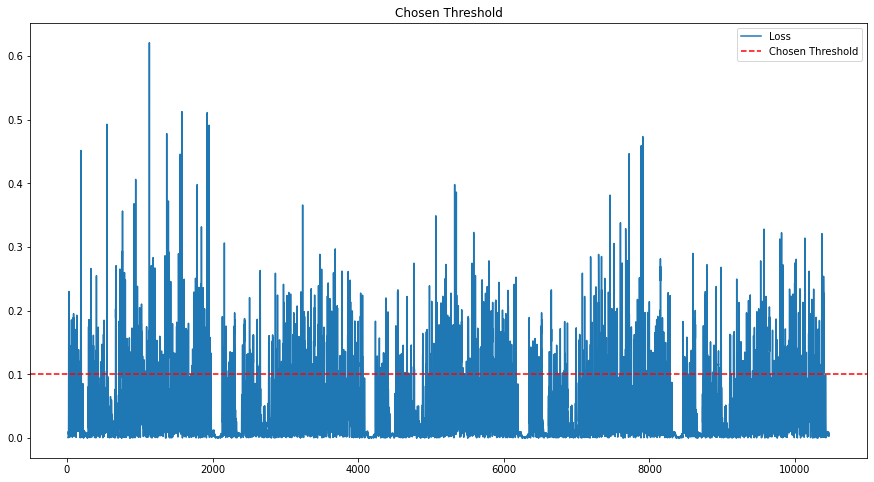

In [49]:
loss_plot(preds_losses, 0.1)

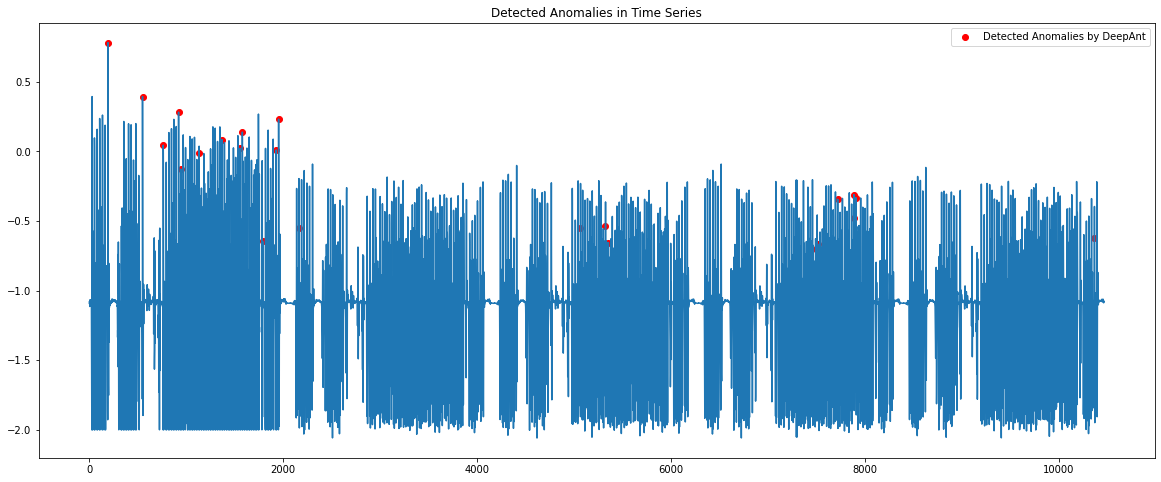

In [52]:
ts_plot(df['value'], preds_losses, 0.3)

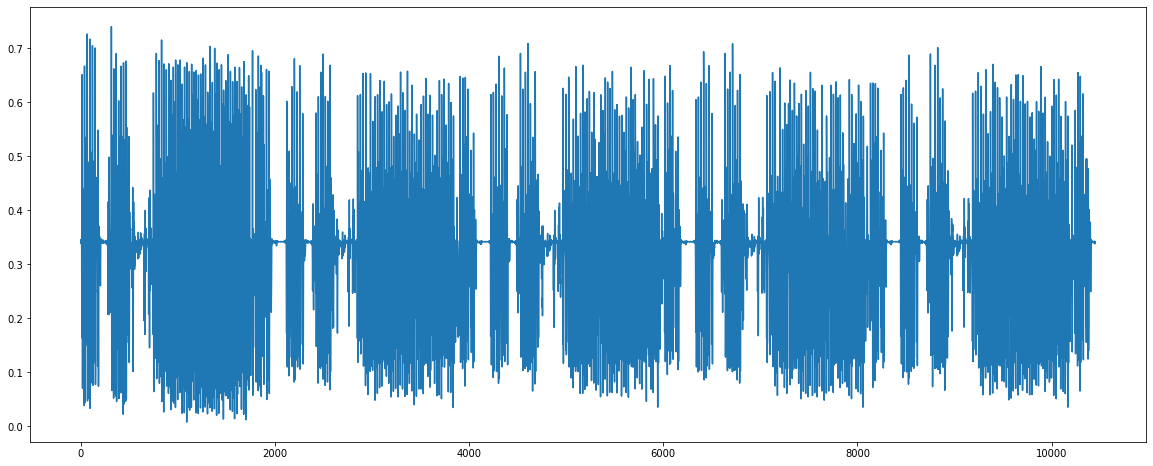

In [51]:
plt.figure(figsize = (20,8))
plt.plot(yhat.reshape(-1,1))

In [22]:
idx = preds_losses.loc[lambda x: x > 0.5].index

In [23]:
idx

Int64Index([8507, 8508, 8509, 8510, 8511, 8512, 8513, 8514, 8515, 8516, 8517,
            8518, 8519, 8520, 8521, 8522, 8868, 8869, 9553],
           dtype='int64')

In [24]:
0.89

0.89